# Primer Punto

In [4]:
pip install mglearn

Note: you may need to restart the kernel to use updated packages.


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mglearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import recall_score, classification_report, make_scorer, r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.datasets import load_breast_cancer
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBClassifier, XGBRegressor
import itertools    

import warnings

warnings.filterwarnings("ignore")

# (CLASIFICACIÓN DE CANCER)

In [7]:
cancer = load_breast_cancer()
X, y = cancer.data, cancer.target
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, random_state=42)


## Metrica usada RECALL
 
El recall emerge como una métrica de evaluación clave al trabajar en la identificación de condiciones médicas, tales como el cáncer de mama, primordialmente debido a las implicaciones significativas asociadas con los falsos negativos. Esta situación adquiere una dimensión crítica en el contexto del cáncer de mama, dado que la detección precoz y el diagnóstico acertado juegan roles fundamentales en mejorar las perspectivas y opciones de tratamiento para el paciente.

$$ Recall = \frac{Verdaderos\ Positivos\ (VP)}{Verdaderos\ Positivos\ (VP) + Falsos\ Negativos\ (FN)}$$


## Manual

In [13]:
param_grid = {
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9],
            'algorithm': ['auto']
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=10000, solver='liblinear'),
        'params': {
            'C': [0.1, 1, 10, 100],
            'penalty': ['l1', 'l2']
        }
    },
    'RandomForestClassifier': {
        'model': RandomForestClassifier(random_state=2),
        'params': {
            'n_estimators': [5, 10, 50],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'DecisionTreeClassifier': {
        'model': DecisionTreeClassifier(random_state=0),
        'params': {
            'max_depth': [3, 4, 5, 6, 7],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'XGBoostClassifier': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 1],
            'colsample_bytree': [0.8, 1],
        }
    },
    'BernoulliNB': {
        'model': BernoulliNB(),
        'params': {
            'alpha': [0.01, 0.1, 1, 10, 100]
        }
    }
}

# Define the custom pipeline function for grid search
def customPipeline(XTrain, XTest, yTrain, yTest):
    results = []
    scaler = StandardScaler()
    XTrainScaled = scaler.fit_transform(XTrain)
    XTestScaled = scaler.transform(XTest)
    
    for modelName, modelInfo in param_grid.items():
        model = modelInfo['model']
        params = modelInfo['params']
        bestModel, bestScore, bestParams = None, 0, None
        
        for param_combination in itertools.product(*params.values()):
            param_dict = dict(zip(params.keys(), param_combination))
            model.set_params(**param_dict)
            cv = StratifiedKFold(n_splits=5)
            recalls = []
            
            for trainIdx, valIdx in cv.split(XTrainScaled, yTrain):
                XTrainFold, XValFold = XTrainScaled[trainIdx], XTrainScaled[valIdx]
                yTrainFold, yValFold = yTrain[trainIdx], yTrain[valIdx]
                
                model.fit(XTrainFold, yTrainFold)
                yPred = model.predict(XValFold)
                recall = recall_score(yValFold, yPred)
                recalls.append(recall)
            
            meanRecall = sum(recalls) / len(recalls)
            
            if meanRecall > bestScore:
                bestScore = meanRecall
                bestModel = model
                bestParams = param_dict
        
        results.append({
            'Model': modelName,
            'Best Recall': bestScore,
            'Best Parameters': bestParams
        })
    
    results_df = pd.DataFrame(results)
    return results_df

In [14]:
customPipeline(XTrain, XTest, yTrain, yTest)

,Model,Best Recall,Best Parameters
0,KNN,0.993043,"{'n_neighbors': 9, 'algorithm': 'auto'}"
1,LogisticRegression,0.993043,"{'C': 0.1, 'penalty': 'l2'}"
2,RandomForestClassifier,0.975439,"{'n_estimators': 50, 'max_depth': None, 'min_s..."
3,DecisionTreeClassifier,0.951059,"{'max_depth': 5, 'min_samples_split': 2, 'min_..."
4,XGBoostClassifier,0.992982,"{'n_estimators': 50, 'max_depth': 5, 'learning..."
5,BernoulliNB,0.930127,{'alpha': 100}


## Con Métodos

In [15]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import BernoulliNB

pipelines = {
    'knn': Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier())
    ]),
    'logistic_regression': Pipeline([
        ('scaler', StandardScaler()),
        ('logistic_regression', LogisticRegression(max_iter=10000, solver='liblinear', penalty='l2'))
    ]),
    'random_forest': Pipeline([
        ('scaler', StandardScaler()),
        ('random_forest', RandomForestClassifier(random_state=2))
    ]),
    'decision_tree': Pipeline([
        ('scaler', StandardScaler()),
        ('decision_tree', DecisionTreeClassifier(random_state=0))
    ]),
    'xgboost': Pipeline([
        ('scaler', StandardScaler()),
        ('xgboost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
    ]),
    'bernoulli_nb': Pipeline([
        ('scaler', StandardScaler()),
        ('bernoulli_nb', BernoulliNB())
    ])
}

param_grid = {
    'knn': {
        'knn__n_neighbors': [3, 5, 7, 9]
    },
    'logistic_regression': {
        'logistic_regression__C': [0.1, 1, 10, 100],
        'logistic_regression__penalty': ['l1', 'l2']
    },
    'random_forest': {
        'random_forest__n_estimators': [5, 10, 50],
        'random_forest__max_depth': [None, 10, 20, 30]
    },
    'decision_tree': {
        'decision_tree__max_depth': [3, 4, 5, 6, 7]
    },
    'xgboost': {
        'xgboost__n_estimators': [50, 100, 200],
        'xgboost__max_depth': [3, 5, 7]
    },
    'bernoulli_nb': {
        'bernoulli_nb__alpha': [0.1, 0.5, 1.0],
        'bernoulli_nb__binarize': [None, 0.0, 0.5]
    }
}

results_df = pd.DataFrame(columns=['Model', 'Best Recall', 'Best Parameters'])

for model_name, pipeline in pipelines.items():
    model_param_grid = param_grid[model_name]
    grid_search = GridSearchCV(pipeline, model_param_grid, cv=StratifiedKFold(n_splits=5), scoring='recall', verbose=1)
    grid_search.fit(XTrain, yTrain)
    
    best_recall = grid_search.best_score_
    best_params = grid_search.best_params_

    results_df = pd.concat([results_df, pd.DataFrame.from_records([{
        'Model': model_name,
        'Best Recall': best_recall,
        'Best Parameters': best_params
    }])], ignore_index=True)

results_df


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


,Model,Best Recall,Best Parameters
0,knn,0.989595,{'knn__n_neighbors': 5}
1,logistic_regression,0.993043,"{'logistic_regression__C': 0.1, 'logistic_regr..."
2,random_forest,0.975439,"{'random_forest__max_depth': None, 'random_for..."
3,decision_tree,0.951059,{'decision_tree__max_depth': 5}
4,xgboost,0.986025,"{'xgboost__max_depth': 3, 'xgboost__n_estimato..."
5,bernoulli_nb,0.968603,"{'bernoulli_nb__alpha': 0.1, 'bernoulli_nb__bi..."


## Decisión

Teniendo en cuenta los resultados de los diferentes modelos de clasificación, tanto mediante métodos automatizados como de forma manual, se puede concluir que los modelos con mejor ajuste a la clasificación de cáncer en términos de la métrica de recall son **XGBoost** y la **regresión logística**.


# Estimación de Velocidad del tiempo

In [16]:
X, y = mglearn.datasets.load_extended_boston()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Manual

In [24]:

param_grid = {
    'Ridge': {
        'model': Ridge(),
        'params': {
            'alpha': [0.1, 1, 10, 100]
        }
    },
    'Lasso': {
        'model': Lasso(),
        'params': {
            'alpha': [0.1, 1, 10, 100]
        }
    },
    'BayesianRidge': {
        'model': BayesianRidge(),
        'params': {
            'alpha_1': [1e-6, 1e-5, 1e-4],
            'alpha_2': [1e-6, 1e-5, 1e-4],
            'lambda_1': [1e-6, 1e-5, 1e-4],
            'lambda_2': [1e-6, 1e-5, 1e-4]
        }
    },
    'DecisionTreeRegressor': {
        'model': DecisionTreeRegressor(),
        'params': {
            'max_depth': [3, 5, 7, None]
        }
    },
    'RandomForestRegressor': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [10, 50, 100],
            'max_depth': [3, 5, 7, None]
        }
    },
    'XGBRegressor': {
        'model': XGBRegressor(objective='reg:squarederror'),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.2]
        }
    },
    'KNeighborsRegressor': {
        'model': KNeighborsRegressor(),
        'params': {
            'n_neighbors': [3, 5, 7, 10],
        }
    }
}

def customPipeline(X_train, X_test, y_train, y_test):
    results = []
    for model_name, model_info in param_grid.items():
        model = model_info['model']
        params = model_info['params']
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        grid_search = GridSearchCV(model, params, cv=5, scoring='r2')
        grid_search.fit(X_train_scaled, y_train)
        best_model = grid_search.best_estimator_
        
        y_pred = best_model.predict(X_test_scaled)
        best_score = r2_score(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)

        results.append({
            'Model': model_name,
            'Best R2 Score': best_score,
            'Best RMSE': rmse,
            'Best Parameters': grid_search.best_params_
        })

    # Crear DataFrame a partir de los resultados
    df = pd.DataFrame(results)
    return df

# Ejemplo de cómo usar el pipeline con tus datos de entrenamiento y prueba
results_df = customPipeline(X_train, X_test, y_train, y_test)
results_df


,Model,Best R2 Score,Best RMSE,Best Parameters
0,Ridge,0.816482,3.584865,{'alpha': 1}
1,Lasso,0.804431,3.700699,{'alpha': 0.1}
2,BayesianRidge,0.822263,3.527944,"{'alpha_1': 1e-06, 'alpha_2': 0.0001, 'lambda_..."
3,DecisionTreeRegressor,0.721034,4.419862,{'max_depth': 5}
4,RandomForestRegressor,0.834431,3.405044,"{'max_depth': 7, 'n_estimators': 10}"
5,XGBRegressor,0.877292,2.931365,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
6,KNeighborsRegressor,0.719164,4.434652,{'n_neighbors': 3}


## Con Métodos

In [ ]:
!pip install theano --upgrade


In [25]:


pipelines = {
    'Ridge': Pipeline([
        ('scaler', StandardScaler()),
        ('ridge', Ridge())
    ]),
    'Lasso': Pipeline([
        ('scaler', StandardScaler()),
        ('lasso', Lasso())
    ]),
    'BayesianRidge': Pipeline([
        ('scaler', StandardScaler()),
        ('bayesian_ridge', BayesianRidge())
    ]), 
    'DecisionTreeRegressor': Pipeline([
        ('scaler', StandardScaler()),
        ('decision_tree', DecisionTreeRegressor())
    ]),
    'RandomForestRegressor': Pipeline([
        ('scaler', StandardScaler()),
        ('random_forest', RandomForestRegressor())
    ]),
    'XGBRegressor': Pipeline([
        ('scaler', StandardScaler()),
        ('xgb_regressor', XGBRegressor(objective='reg:squarederror'))
    ]),
    'KNeighborsRegressor': Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsRegressor())
    ])
}

# Define los parámetros para GridSearchCV para cada modelo, incluyendo parámetros para KNeighborsRegressor
param_grid = {
    'Ridge': {
        'ridge__alpha': [0.1, 1, 10, 100]
    },
    'Lasso': {
        'lasso__alpha': [0.1, 1, 10, 100]
    },
    'BayesianRidge': {
        'bayesian_ridge__n_iter': [100, 200, 300],
        'bayesian_ridge__alpha_1': [1e-6, 1e-5, 1e-4],
        'bayesian_ridge__alpha_2': [1e-6, 1e-5, 1e-4],
        'bayesian_ridge__lambda_1': [1e-6, 1e-5, 1e-4],
        'bayesian_ridge__lambda_2': [1e-6, 1e-5, 1e-4]
    },
    'DecisionTreeRegressor': {
        'decision_tree__max_depth': [3, 5, 7, None]
    },
    'RandomForestRegressor': {
        'random_forest__n_estimators': [10, 50, 100],
        'random_forest__max_depth': [3, 5, 7, None]
    },
    'XGBRegressor': {
        'xgb_regressor__n_estimators': [50, 100, 200],
        'xgb_regressor__max_depth': [3, 5, 7],
        'xgb_regressor__learning_rate': [0.01, 0.1, 0.2]
    },
    'KNeighborsRegressor': {
        'knn__n_neighbors': [3, 5, 7, 10],
        'knn__weights': ['uniform', 'distance'],
        'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }
}

results_df = pd.DataFrame(columns=['Model', 'Best R2 Score', 'Best RMSE', 'Best Parameters'])

for model_name, pipeline in pipelines.items():
    model_param_grid = param_grid[model_name]
    grid_search = GridSearchCV(pipeline, model_param_grid, cv=5, scoring='r2')
    grid_search.fit(X_train, y_train)
    
    best_r2 = grid_search.best_score_
    best_params = grid_search.best_params_
    best_estimator = grid_search.best_estimator_

    # Evalúa el modelo en el conjunto de prueba
    y_pred = best_estimator.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    # Almacena los resultados en un DataFrame
    results_df = pd.concat([results_df, pd.DataFrame.from_records([{
        'Model': model_name,
        'Best R2 Score': best_r2,
        'Best RMSE': rmse,
        'Best Parameters': best_params
    }])], ignore_index=True)

results_df


,Model,Best R2 Score,Best RMSE,Best Parameters
0,Ridge,0.858028,3.584865,{'ridge__alpha': 1}
1,Lasso,0.815944,3.700699,{'lasso__alpha': 0.1}
2,BayesianRidge,0.854589,3.527944,"{'bayesian_ridge__alpha_1': 1e-06, 'bayesian_r..."
3,DecisionTreeRegressor,0.781182,3.580205,{'decision_tree__max_depth': 5}
4,RandomForestRegressor,0.860390,3.268379,"{'random_forest__max_depth': 7, 'random_forest..."
5,XGBRegressor,0.882557,2.931365,"{'xgb_regressor__learning_rate': 0.1, 'xgb_reg..."
6,KNeighborsRegressor,0.785947,4.285245,"{'knn__algorithm': 'auto', 'knn__n_neighbors':..."


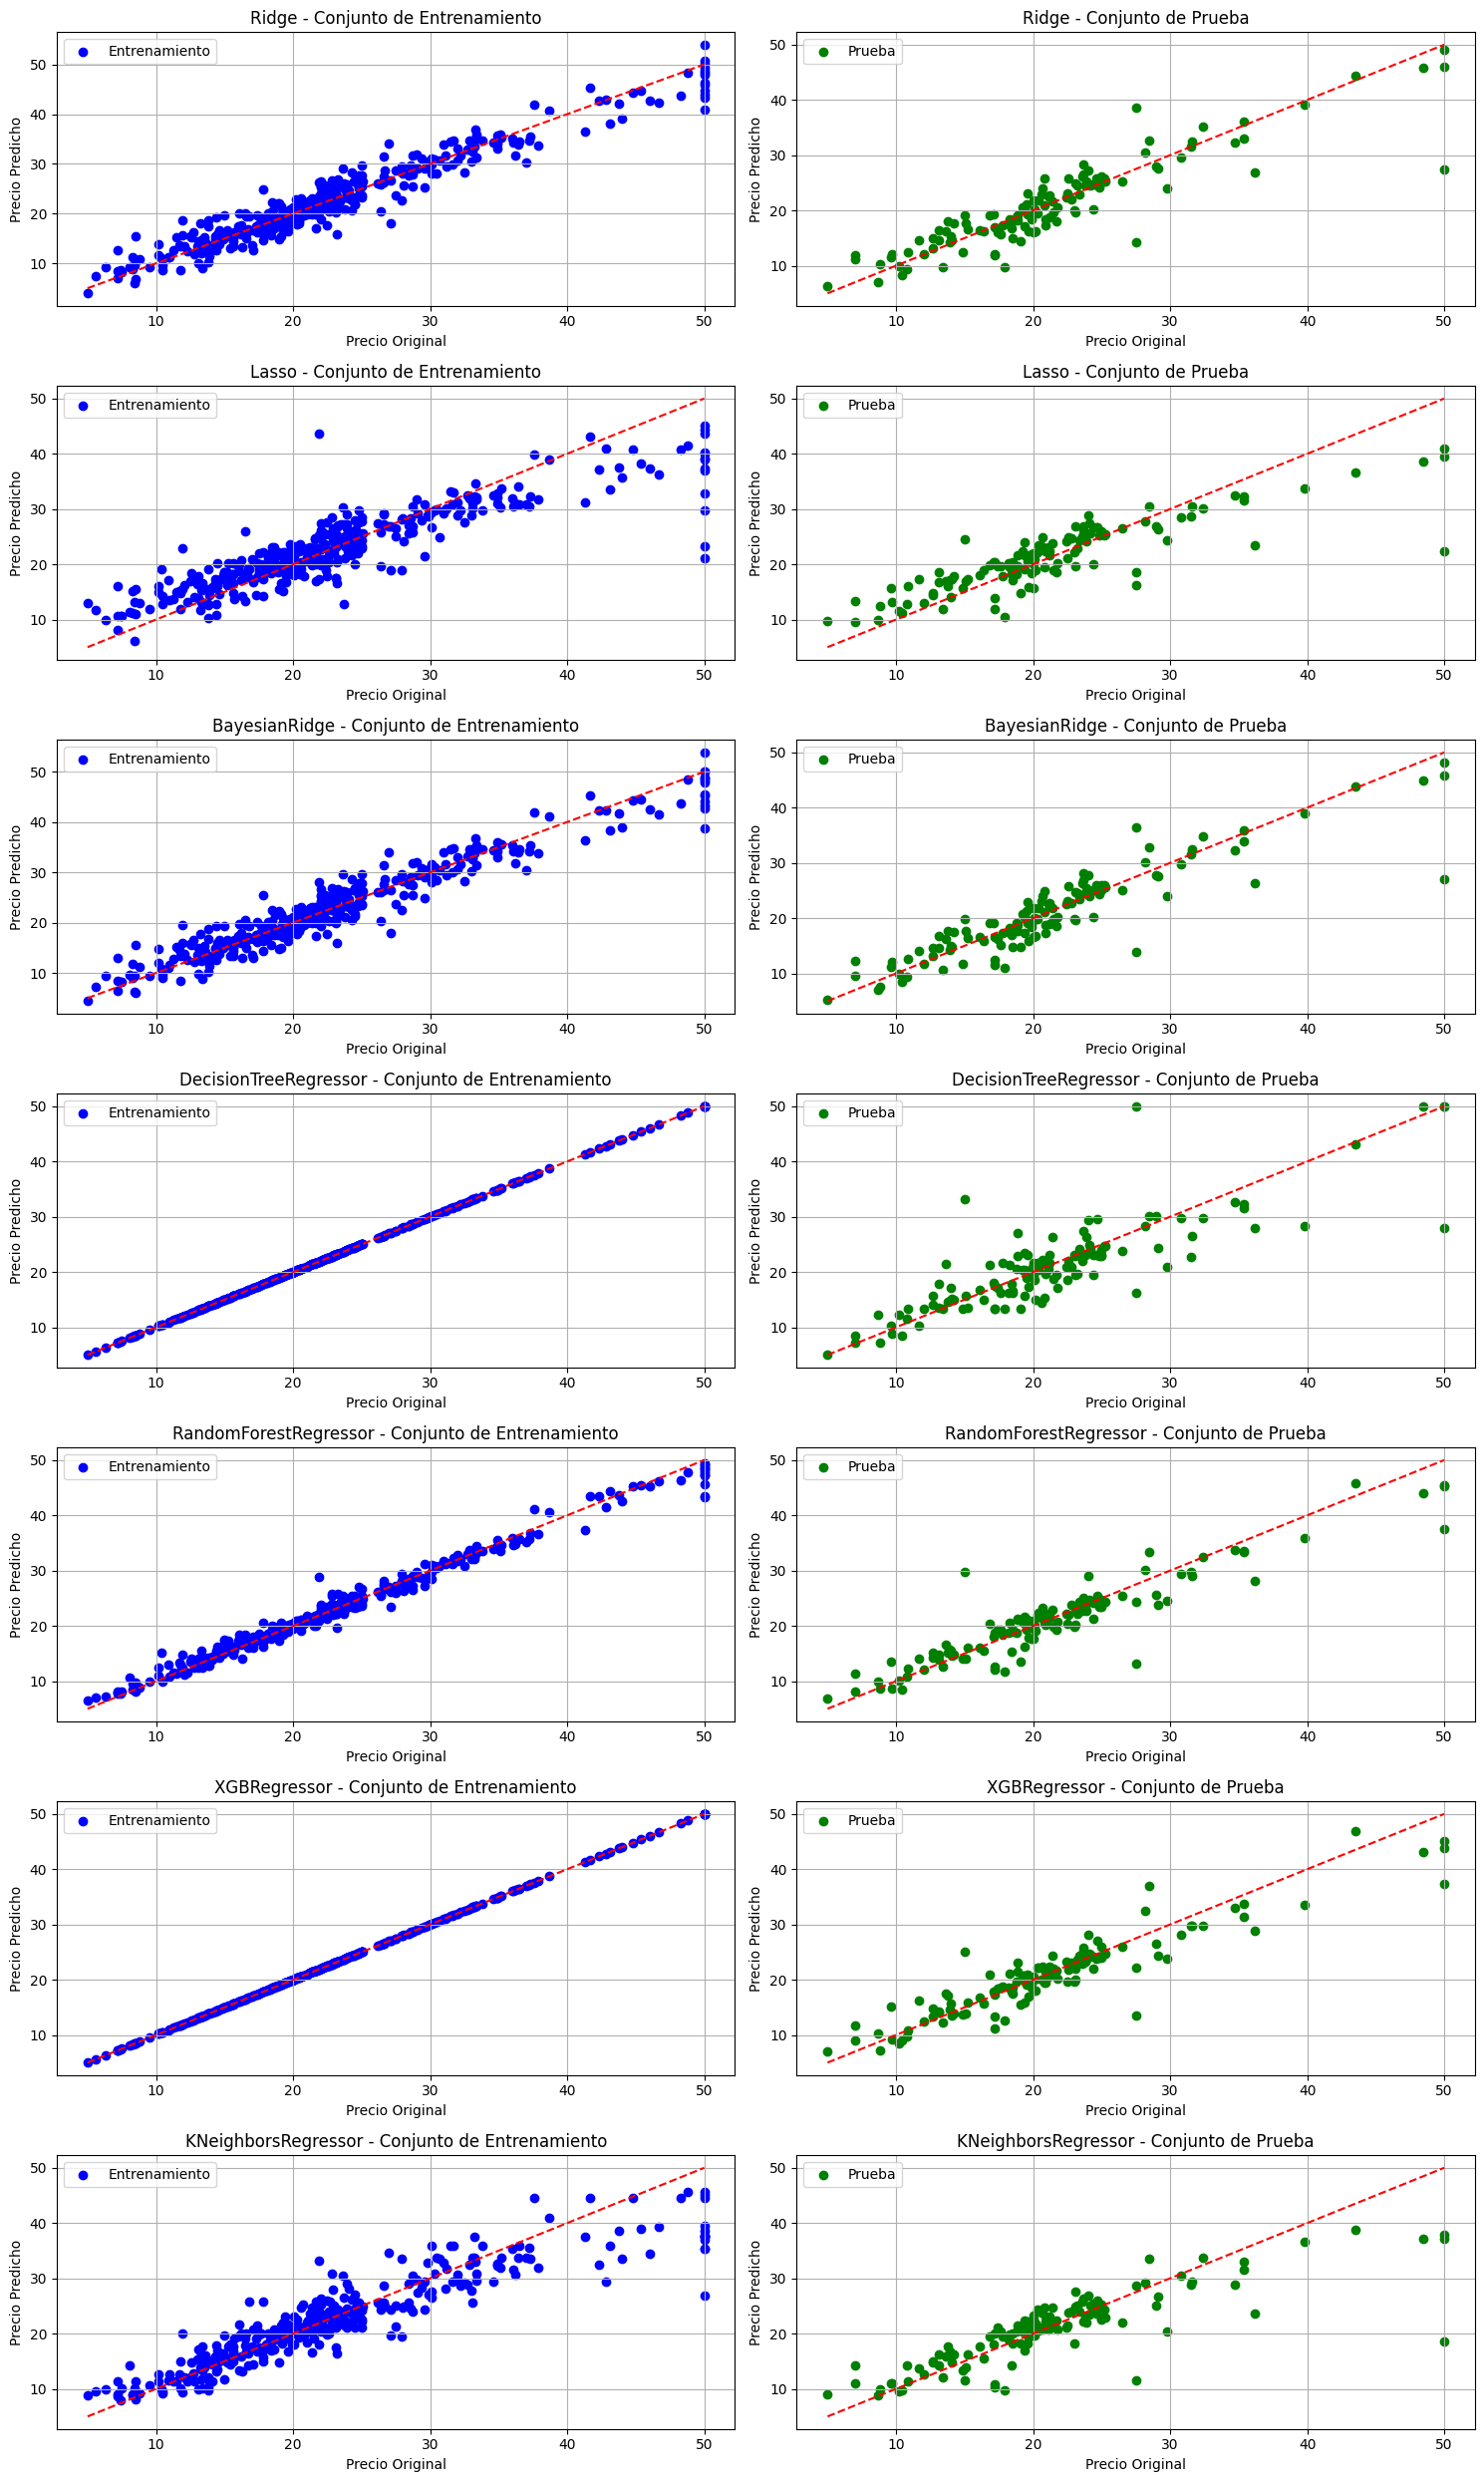

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Crear una matriz de subgráficos 5x2
fig, axs = plt.subplots(7, 2, figsize=(15, 25))

# Iterar sobre cada modelo y graficar
for idx, (model_name, pipeline) in enumerate(pipelines.items()):
    pipeline.fit(X_train, y_train)
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    # Gráfico para el conjunto de entrenamiento
    axs[idx, 0].scatter(y_train, y_train_pred, color='blue', label='Entrenamiento')
    axs[idx, 0].plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--')
    axs[idx, 0].set_title(f'{model_name} - Conjunto de Entrenamiento')
    axs[idx, 0].set_xlabel('Precio Original')
    axs[idx, 0].set_ylabel('Precio Predicho')
    axs[idx, 0].legend()
    axs[idx, 0].grid(True)

    # Gráfico para el conjunto de prueba
    axs[idx, 1].scatter(y_test, y_test_pred, color='green', label='Prueba')
    axs[idx, 1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    axs[idx, 1].set_title(f'{model_name} - Conjunto de Prueba')
    axs[idx, 1].set_xlabel('Precio Original')
    axs[idx, 1].set_ylabel('Precio Predicho')
    axs[idx, 1].legend()
    axs[idx, 1].grid(True)

# Ajustar la disposición de los subgráficos
plt.tight_layout()
plt.show()


## Decisión
Los resultados de los diferentes modelos de Regresión asi como sus respectivas gráficas,muestran que todos tuvieron un buen desempeño, siendo **XGBRegressor** el mejor tanto en términos de R2 (que mide la proporción de la varianza de la variable dependiente que es predecible a partir de las variables independientes) como en términos de RMSE (Root Mean Square Error, que mide la diferencia entre los valores predichos por el modelo y los valores reales).


# ADASYN (Adaptive Synthetic)
Consiste en una técnica de sobremuestreo utilizada en el aprendizaje automático para abordar el desequilibrio en conjuntos de datos de clasificación. A diferencia del método SMOTE, ADASYN ajusta la cantidad de muestras sintéticas generadas según la distribución local de la clase minoritaria. Esto significa que se prioriza la generación de datos sintéticos en áreas del espacio de características donde la clase minoritaria está menos representada, lo que ayuda a mejorar la capacidad del modelo para generalizar y clasificar correctamente las instancias de la clase minoritaria. Este enfoque adaptativo ayuda a mitigar el riesgo de sobreajuste en modelos de aprendizaje automático.

ADASYN determina la distribución local de la clase minoritaria calculando la densidad de puntos cercanos en el espacio de características. Luego, asigna pesos a cada instancia de la clase minoritaria en función de esta distribución local. Las instancias con menor densidad de puntos cercanos reciben pesos más altos, lo que significa que se les da más importancia durante la generación de datos sintéticos. De esta manera, ADASYN prioriza la generación de muestras sintéticas en áreas donde la clase minoritaria está subrepresentada, lo que ayuda a equilibrar el conjunto de datos y mejorar el rendimiento del modelo en la clasificación de instancias minoritarias.